# Import necessary libraries

In [9]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

In [10]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [12]:
# Groups of images were prepared using base image identifiers
image_groups = {}
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])  # Base ID was extracted before augmentation tags
    if original_id not in image_groups:
        image_groups[original_id] = []
    image_groups[original_id].append(img_path)

# Group keys were shuffled to ensure random distribution
random.seed(42)
group_keys = list(image_groups.keys())
random.shuffle(group_keys)

# The dataset was split into training (70%), validation (15%), and test (15%) sets
total = len(group_keys)
train_size = round(0.70 * total)
val_size = round(0.20 * total)
test_size = total - train_size - val_size

train_keys = set(group_keys[:train_size])
val_keys = set(group_keys[train_size:train_size + val_size])
test_keys = set(group_keys[train_size + val_size:])

# Indices were assigned to the appropriate split based on the group identifier
train_indices, val_indices, test_indices = [], [], []

for idx, (img_path, _) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])
    if original_id in train_keys:
        train_indices.append(idx)
    elif original_id in val_keys:
        val_indices.append(idx)
    elif original_id in test_keys:
        test_indices.append(idx)

# Subsets were created for each split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# Data loaders were initialized for model1training and evaluation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3462
Validation samples: 956
Test samples: 482


In [13]:
import timm
import torch
import torch.nn as nn

model = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze input (patch embedding) layer
for param in model.patch_embed.parameters():
    param.requires_grad = True

# Unfreeze output (classification head) layer
for param in model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded, and moved to {device}")
print("Only input (patch_embed) and output (head) layers are trainable.")

Model loaded, and moved to cpu
Only input (patch_embed) and output (head) layers are trainable.


In [14]:
import torch.optim.lr_scheduler as lr_scheduler

# Defining loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [16]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "DeiT_best_model.pth")
            print("Model improved. Checkpoint saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history
history1 = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=15)

Epoch 1/20: 100%|█████████████████████████████| 109/109 [04:45<00:00,  2.62s/it]


Epoch 1/20: Train Loss: 1.0593, Train Acc: 61.47% | Val Loss: 0.8779, Val Acc: 68.72%
Model improved. Checkpoint saved.


Epoch 2/20: 100%|█████████████████████████████| 109/109 [07:58<00:00,  4.39s/it]


Epoch 2/20: Train Loss: 0.6972, Train Acc: 75.16% | Val Loss: 0.6341, Val Acc: 77.93%
Model improved. Checkpoint saved.


Epoch 3/20: 100%|█████████████████████████████| 109/109 [09:28<00:00,  5.22s/it]


Epoch 3/20: Train Loss: 0.5414, Train Acc: 80.82% | Val Loss: 0.6180, Val Acc: 75.21%
Model improved. Checkpoint saved.


Epoch 4/20: 100%|█████████████████████████████| 109/109 [10:26<00:00,  5.75s/it]


Epoch 4/20: Train Loss: 0.4260, Train Acc: 85.44% | Val Loss: 0.5405, Val Acc: 78.66%
Model improved. Checkpoint saved.


Epoch 5/20: 100%|█████████████████████████████| 109/109 [08:06<00:00,  4.46s/it]


Epoch 5/20: Train Loss: 0.3938, Train Acc: 86.14% | Val Loss: 0.5877, Val Acc: 77.82%
No improvement. Early stopping counter: 1/15


Epoch 6/20: 100%|█████████████████████████████| 109/109 [07:55<00:00,  4.36s/it]


Epoch 6/20: Train Loss: 0.3035, Train Acc: 89.80% | Val Loss: 0.5014, Val Acc: 79.71%
Model improved. Checkpoint saved.


Epoch 7/20: 100%|█████████████████████████████| 109/109 [08:06<00:00,  4.47s/it]


Epoch 7/20: Train Loss: 0.2460, Train Acc: 91.88% | Val Loss: 0.4397, Val Acc: 83.26%
Model improved. Checkpoint saved.


Epoch 8/20: 100%|█████████████████████████████| 109/109 [08:10<00:00,  4.50s/it]


Epoch 8/20: Train Loss: 0.2420, Train Acc: 91.77% | Val Loss: 0.5132, Val Acc: 82.11%
No improvement. Early stopping counter: 1/15


Epoch 9/20: 100%|█████████████████████████████| 109/109 [08:17<00:00,  4.56s/it]


Epoch 9/20: Train Loss: 0.2028, Train Acc: 93.36% | Val Loss: 0.4781, Val Acc: 83.16%
No improvement. Early stopping counter: 2/15


Epoch 10/20: 100%|████████████████████████████| 109/109 [08:22<00:00,  4.61s/it]


Epoch 10/20: Train Loss: 0.1053, Train Acc: 97.57% | Val Loss: 0.4734, Val Acc: 83.58%
No improvement. Early stopping counter: 3/15


Epoch 11/20: 100%|████████████████████████████| 109/109 [08:25<00:00,  4.64s/it]


Epoch 11/20: Train Loss: 0.0866, Train Acc: 97.98% | Val Loss: 0.4511, Val Acc: 82.53%
No improvement. Early stopping counter: 4/15


Epoch 12/20: 100%|████████████████████████████| 109/109 [08:47<00:00,  4.84s/it]


Epoch 12/20: Train Loss: 0.0518, Train Acc: 99.22% | Val Loss: 0.4025, Val Acc: 84.62%
Model improved. Checkpoint saved.


Epoch 13/20: 100%|████████████████████████████| 109/109 [08:07<00:00,  4.47s/it]


Epoch 13/20: Train Loss: 0.0377, Train Acc: 99.77% | Val Loss: 0.4006, Val Acc: 84.52%
Model improved. Checkpoint saved.


Epoch 14/20: 100%|████████████████████████████| 109/109 [07:55<00:00,  4.36s/it]


Epoch 14/20: Train Loss: 0.0237, Train Acc: 99.86% | Val Loss: 0.3967, Val Acc: 85.15%
Model improved. Checkpoint saved.


Epoch 15/20: 100%|████████████████████████████| 109/109 [08:02<00:00,  4.43s/it]


Epoch 15/20: Train Loss: 0.0197, Train Acc: 99.91% | Val Loss: 0.4070, Val Acc: 85.36%
No improvement. Early stopping counter: 1/15


Epoch 16/20: 100%|████████████████████████████| 109/109 [07:56<00:00,  4.37s/it]


Epoch 16/20: Train Loss: 0.0177, Train Acc: 99.88% | Val Loss: 0.4039, Val Acc: 85.56%
No improvement. Early stopping counter: 2/15


Epoch 17/20: 100%|████████████████████████████| 109/109 [08:14<00:00,  4.54s/it]


Epoch 17/20: Train Loss: 0.0163, Train Acc: 99.91% | Val Loss: 0.3994, Val Acc: 84.73%
No improvement. Early stopping counter: 3/15


Epoch 18/20: 100%|████████████████████████████| 109/109 [08:19<00:00,  4.58s/it]


Epoch 18/20: Train Loss: 0.0155, Train Acc: 99.94% | Val Loss: 0.4026, Val Acc: 85.04%
No improvement. Early stopping counter: 4/15


Epoch 19/20: 100%|████████████████████████████| 109/109 [08:31<00:00,  4.70s/it]


Epoch 19/20: Train Loss: 0.0149, Train Acc: 99.94% | Val Loss: 0.4032, Val Acc: 84.73%
No improvement. Early stopping counter: 5/15


Epoch 20/20: 100%|████████████████████████████| 109/109 [08:35<00:00,  4.73s/it]


Epoch 20/20: Train Loss: 0.0145, Train Acc: 99.94% | Val Loss: 0.4035, Val Acc: 84.62%
No improvement. Early stopping counter: 6/15


# Plotting Training & Validation Loss and Accuracy

In [24]:
import sys

# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_model_artifacts, handle_dataset

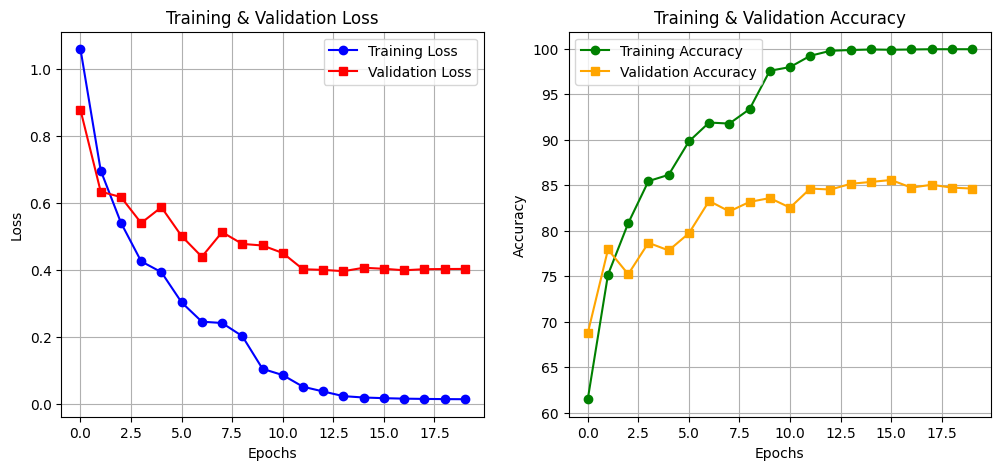

In [25]:
plotting(history1)

# Computeing Performance Metrics

In [29]:
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve, auc,
    precision_recall_fscore_support, matthews_corrcoef, cohen_kappa_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize

def evaluate_model(model, dataloader, class_names=dataset.classes, top_k=(1, 5), loader_name="Validation", model_name="Model"):
    print(f"\n========== Evaluating {model_name} on {loader_name} Set ==========\n")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    top_k_correct = {k: 0 for k in top_k}
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            top_k_preds = torch.topk(outputs, max(top_k), dim=1).indices.cpu().numpy()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for k in top_k:
                top_k_correct[k] += np.sum(labels.cpu().numpy()[:, None] == top_k_preds[:, :k])
            total_samples += labels.size(0)

    inference_time = time.time() - start_time
    avg_inference_time = inference_time / total_samples

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    accuracy = np.trace(cm) / np.sum(cm) * 100
    error_rate = 100 - accuracy
    precision = np.diag(cm) / np.where(np.sum(cm, axis=0) == 0, 1, np.sum(cm, axis=0)) * 100
    recall = np.diag(cm) / np.where(np.sum(cm, axis=1) == 0, 1, np.sum(cm, axis=1)) * 100
    tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / np.where((tn + fp) == 0, 1, (tn + fp)) * 100

    f1_macro = f1_score(all_labels, all_preds, average="macro") * 100
    f1_weighted = f1_score(all_labels, all_preds, average="weighted") * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    mcc = matthews_corrcoef(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100

    n_classes = len(class_names) if class_names is not None else np.max(all_labels) + 1
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]

    if n_classes > 1:
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(n_classes))
        roc_auc = roc_auc_score(all_labels_binarized, all_probs, multi_class="ovr") * 100
    else:
        roc_auc = None

    top_k_accuracy = {f"Top-{k} Accuracy (%)": (top_k_correct[k] / total_samples) * 100 for k in top_k}

    unique_classes, support = np.unique(all_labels, return_counts=True)
    support_df = pd.DataFrame({
        "Class": class_names,
        "Support (Samples)": support
    })

    metrics_df = pd.DataFrame({
        "Class": class_names,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1_per_class,
        "Specificity (%)": specificity
    }).round(2)

    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    print(f"Overall Error Rate: {error_rate:.2f}%")
    print(f"F1-Score (Macro-Averaged): {f1_macro:.2f}%")
    print(f"F1-Score (Weighted): {f1_weighted:.2f}%")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}%")
    print(f"Cohen’s Kappa Score: {kappa:.2f}%")
    for k, acc in top_k_accuracy.items():
        print(f"{k}: {acc:.2f}%")
    print(f"\nAverage Inference Time per Image: {avg_inference_time:.6f} seconds")
    print("\nClass-Wise Performance Metrics:")
    print(metrics_df.to_string(index=False))
    print("\nClass-Wise Sample Distribution:")
    print(support_df.to_string(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    if roc_auc is not None:
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc_val:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(8, 6))
    for class_idx, class_name in enumerate(class_names):
        y_true = (all_labels == class_idx).astype(int)
        y_scores = (all_preds == class_idx).astype(int)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        plt.plot(recall_curve, precision_curve, label=f"{class_name} (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": round(accuracy, 2),
        "error_rate": round(error_rate, 2),
        "f1_macro": round(f1_macro, 2),
        "f1_weighted": round(f1_weighted, 2),
        "roc_auc": round(roc_auc, 2) if roc_auc is not None else "N/A",
        "mcc": round(mcc, 2),
        "kappa": round(kappa, 2),
        "top_k_accuracy": top_k_accuracy,
        "avg_inference_time": avg_inference_time,
        "class_metrics": metrics_df.to_dict(orient="records"),
        "class_support": support_df.to_dict(orient="records")
    }

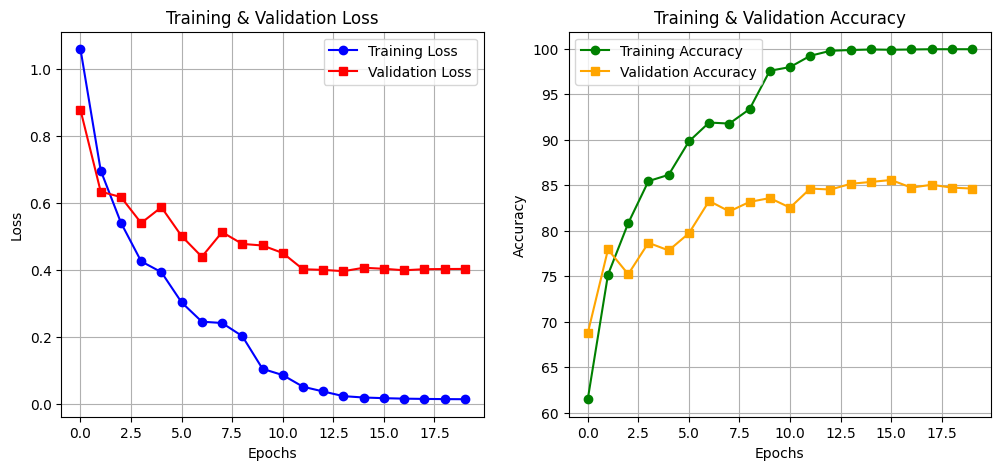


========== Evaluating DeiT-Small V1 on Validation Set ==========


Overall Accuracy: 84.62%
Overall Error Rate: 15.38%
F1-Score (Macro-Averaged): 84.89%
F1-Score (Weighted): 84.61%
Matthews Correlation Coefficient (MCC): 82.05%
Cohen’s Kappa Score: 82.04%
Top-1 Accuracy (%): 84.62%
Top-5 Accuracy (%): 99.90%

Average Inference Time per Image: 0.046249 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          79.62       76.22         77.88            95.96
 BRRI_28          86.26       88.28         87.26            97.83
 BRRI_29          77.14       79.41         78.26            96.10
 BRRI_34          83.21       82.01         82.61            97.18
 BRRI_50          87.20       89.34         88.26            98.08
 BRRI_74          94.07       92.70         93.38            99.02
    BR_5          86.26       86.92         86.59            97.82

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_10

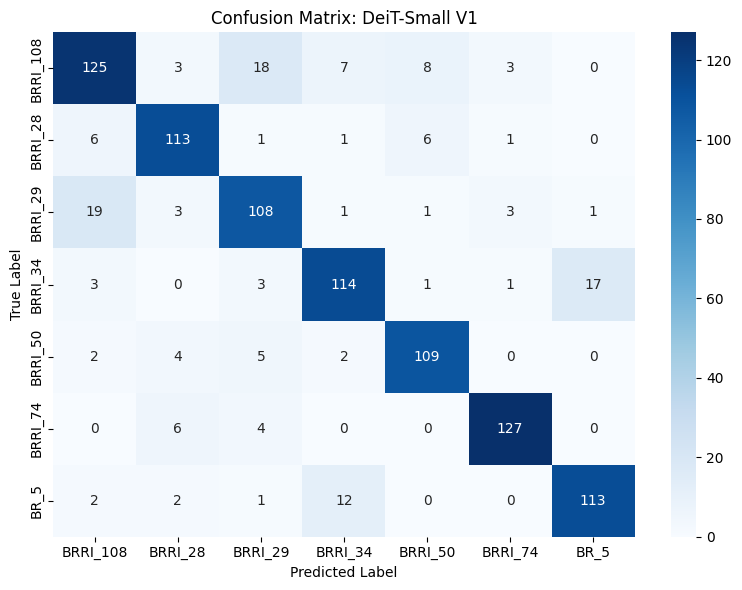

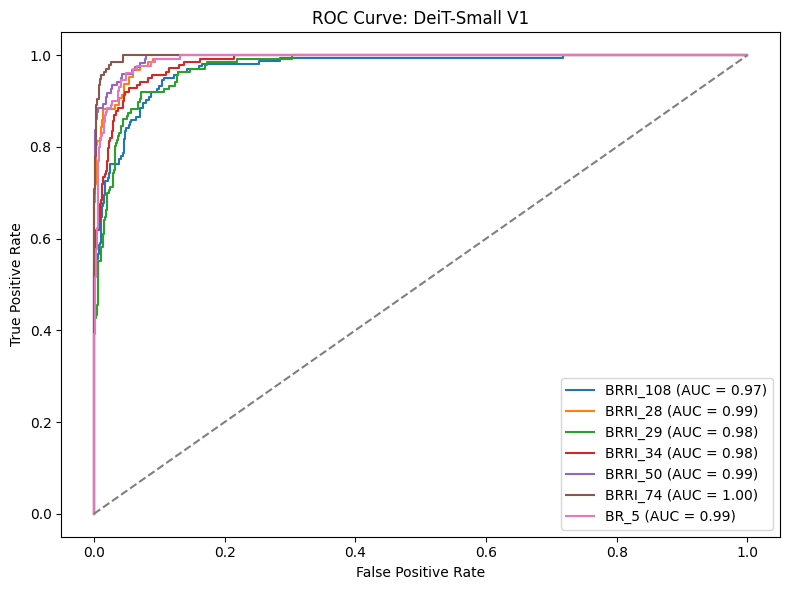

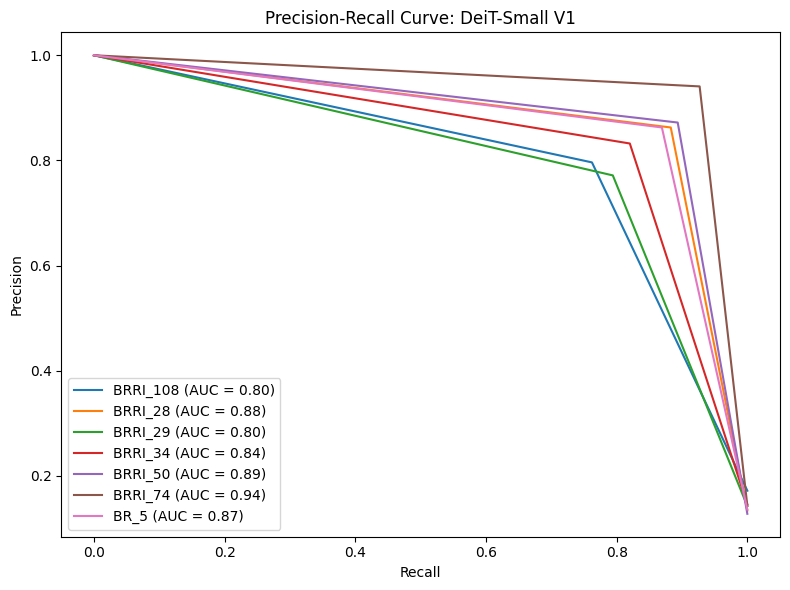


========== Evaluating DeiT-Small V1 on Tesing Set ==========


Overall Accuracy: 85.89%
Overall Error Rate: 14.11%
F1-Score (Macro-Averaged): 85.92%
F1-Score (Weighted): 85.92%
Matthews Correlation Coefficient (MCC): 83.52%
Cohen’s Kappa Score: 83.51%
Top-1 Accuracy (%): 85.89%
Top-5 Accuracy (%): 99.79%

Average Inference Time per Image: 0.045281 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          73.85       75.00         74.42            95.93
 BRRI_28          91.03       86.59         88.75            98.25
 BRRI_29          75.00       76.12         75.56            95.90
 BRRI_34          83.33       84.42         83.87            96.79
 BRRI_50          92.96       97.06         94.96            98.79
 BRRI_74          96.61       93.44         95.00            99.52
    BR_5          88.89       88.89         88.89            98.33

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108   

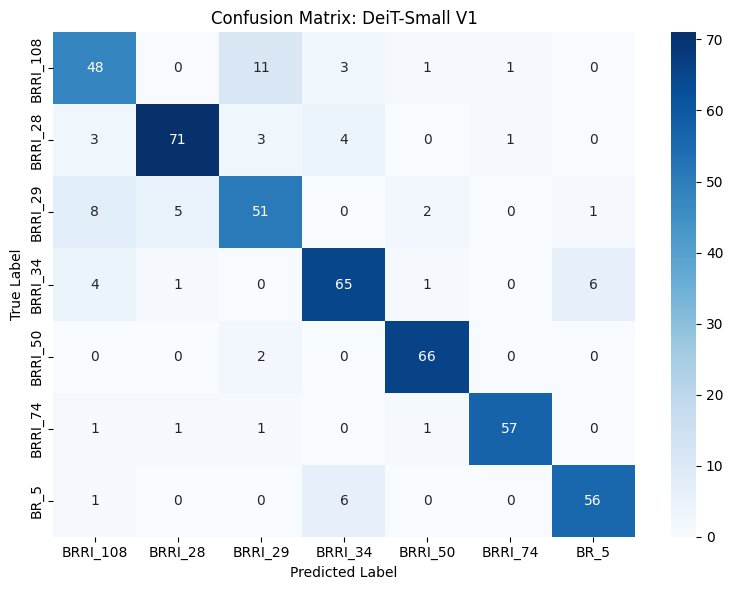

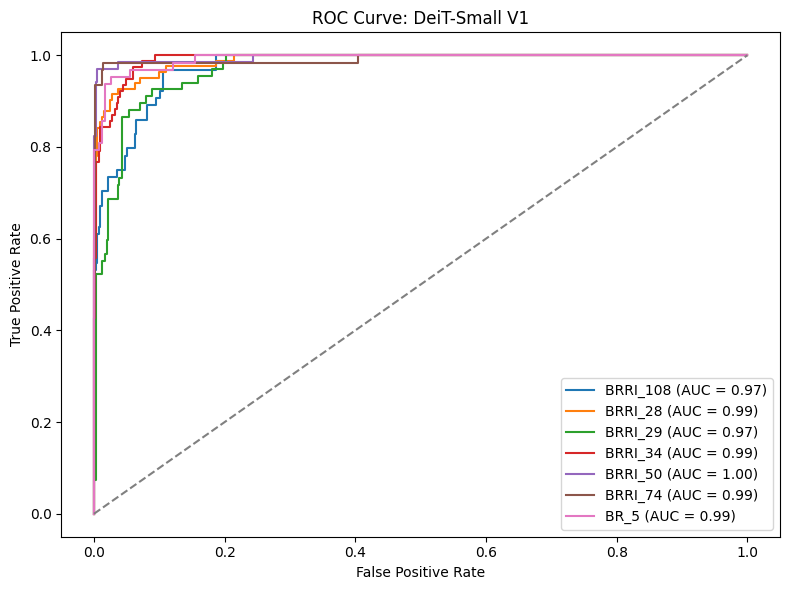

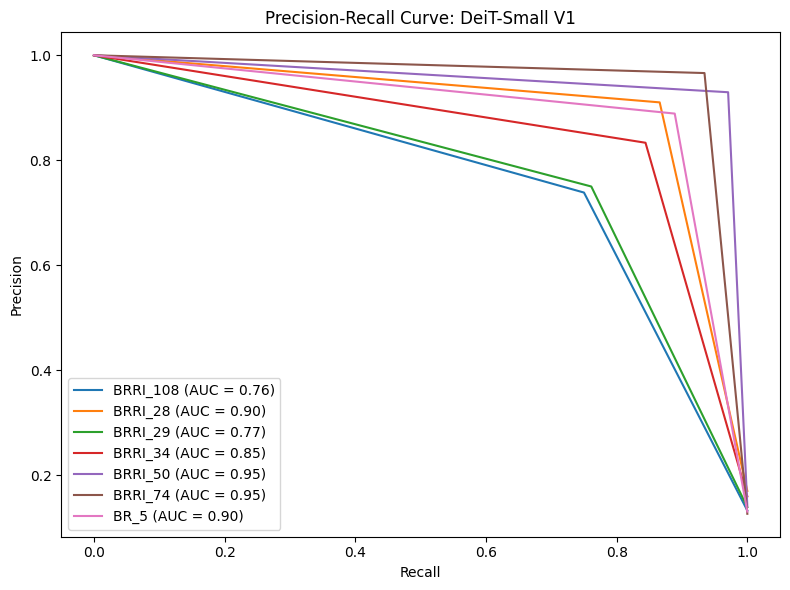

In [30]:
plotting(history1)
metrics = evaluate_model(model, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="DeiT-Small V1")
metrics = evaluate_model(model, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="DeiT-Small V1")

In [31]:
save_model_artifacts(model=model,history=history1,metrics=metrics1,model_name="DeiT_small_Final",version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/DeiT_small_Final_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/DeiT_small_Final/DeiT_small_Final_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/DeiT_small_Final_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/DeiT_small_Final_class_wise_metrics_1.csv


In [33]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Model architecture
model2 = timm.create_model("deit_small_patch16_224", pretrained=True, num_classes=num_classes)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.patch_embed.parameters():
    param.requires_grad = True
for param in model2.head.parameters():
    param.requires_grad = True

# Load saved weights
checkpoint_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/DeiT_small_Final/DeiT_small_Final_1.pth"
model2.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

print(f"Model reloaded from {checkpoint_path} and moved to {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

Model reloaded from /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/DeiT_small_Final/DeiT_small_Final_1.pth and moved to cpu


In [34]:
history2 = train(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=30
)

Epoch 1/30: 100%|█████████████████████████████| 109/109 [07:08<00:00,  3.93s/it]


Epoch 1/30: Train Loss: 0.2493, Train Acc: 91.07% | Val Loss: 0.5659, Val Acc: 80.13%
Model improved. Checkpoint saved.


Epoch 2/30: 100%|█████████████████████████████| 109/109 [07:12<00:00,  3.97s/it]


Epoch 2/30: Train Loss: 0.1911, Train Acc: 93.56% | Val Loss: 0.4769, Val Acc: 82.53%
Model improved. Checkpoint saved.


Epoch 3/30: 100%|█████████████████████████████| 109/109 [07:12<00:00,  3.97s/it]


Epoch 3/30: Train Loss: 0.1662, Train Acc: 94.28% | Val Loss: 0.4682, Val Acc: 83.16%
Model improved. Checkpoint saved.


Epoch 4/30: 100%|█████████████████████████████| 109/109 [06:36<00:00,  3.64s/it]


Epoch 4/30: Train Loss: 0.1695, Train Acc: 94.05% | Val Loss: 0.9749, Val Acc: 69.77%
No improvement. Early stopping counter: 1/15


Epoch 5/30: 100%|█████████████████████████████| 109/109 [06:46<00:00,  3.73s/it]


Epoch 5/30: Train Loss: 0.2053, Train Acc: 93.07% | Val Loss: 0.5168, Val Acc: 81.69%
No improvement. Early stopping counter: 2/15


Epoch 6/30: 100%|█████████████████████████████| 109/109 [07:08<00:00,  3.94s/it]


Epoch 6/30: Train Loss: 0.1159, Train Acc: 96.48% | Val Loss: 0.4318, Val Acc: 83.79%
Model improved. Checkpoint saved.


Epoch 7/30: 100%|█████████████████████████████| 109/109 [06:50<00:00,  3.76s/it]


Epoch 7/30: Train Loss: 0.1515, Train Acc: 94.89% | Val Loss: 0.6699, Val Acc: 77.72%
No improvement. Early stopping counter: 1/15


Epoch 8/30: 100%|█████████████████████████████| 109/109 [07:05<00:00,  3.90s/it]


Epoch 8/30: Train Loss: 0.1852, Train Acc: 93.91% | Val Loss: 0.4627, Val Acc: 83.89%
No improvement. Early stopping counter: 2/15


Epoch 9/30: 100%|█████████████████████████████| 109/109 [06:37<00:00,  3.65s/it]


Epoch 9/30: Train Loss: 0.0486, Train Acc: 98.73% | Val Loss: 0.4070, Val Acc: 85.04%
Model improved. Checkpoint saved.


Epoch 10/30: 100%|████████████████████████████| 109/109 [06:23<00:00,  3.52s/it]


Epoch 10/30: Train Loss: 0.0624, Train Acc: 98.30% | Val Loss: 0.4051, Val Acc: 86.40%
Model improved. Checkpoint saved.


Epoch 11/30: 100%|████████████████████████████| 109/109 [06:23<00:00,  3.52s/it]


Epoch 11/30: Train Loss: 0.0163, Train Acc: 99.80% | Val Loss: 0.3930, Val Acc: 86.61%
Model improved. Checkpoint saved.


Epoch 12/30: 100%|████████████████████████████| 109/109 [06:43<00:00,  3.70s/it]


Epoch 12/30: Train Loss: 0.0074, Train Acc: 99.94% | Val Loss: 0.3957, Val Acc: 86.92%
No improvement. Early stopping counter: 1/15


Epoch 13/30: 100%|████████████████████████████| 109/109 [05:47<00:00,  3.19s/it]


Epoch 13/30: Train Loss: 0.0051, Train Acc: 99.94% | Val Loss: 0.4058, Val Acc: 86.30%
No improvement. Early stopping counter: 2/15


Epoch 14/30: 100%|████████████████████████████| 109/109 [05:48<00:00,  3.20s/it]


Epoch 14/30: Train Loss: 0.0044, Train Acc: 99.97% | Val Loss: 0.3963, Val Acc: 86.40%
No improvement. Early stopping counter: 3/15


Epoch 15/30: 100%|████████████████████████████| 109/109 [05:54<00:00,  3.25s/it]


Epoch 15/30: Train Loss: 0.0039, Train Acc: 99.97% | Val Loss: 0.4046, Val Acc: 86.82%
No improvement. Early stopping counter: 4/15


Epoch 16/30: 100%|████████████████████████████| 109/109 [05:05<00:00,  2.80s/it]


Epoch 16/30: Train Loss: 0.0035, Train Acc: 99.97% | Val Loss: 0.4104, Val Acc: 86.82%
No improvement. Early stopping counter: 5/15


Epoch 17/30: 100%|████████████████████████████| 109/109 [05:10<00:00,  2.85s/it]


Epoch 17/30: Train Loss: 0.0033, Train Acc: 99.97% | Val Loss: 0.4154, Val Acc: 86.51%
No improvement. Early stopping counter: 6/15


Epoch 18/30: 100%|████████████████████████████| 109/109 [05:11<00:00,  2.86s/it]


Epoch 18/30: Train Loss: 0.0031, Train Acc: 99.97% | Val Loss: 0.4157, Val Acc: 86.82%
No improvement. Early stopping counter: 7/15


Epoch 19/30: 100%|████████████████████████████| 109/109 [05:29<00:00,  3.03s/it]


Epoch 19/30: Train Loss: 0.0029, Train Acc: 99.97% | Val Loss: 0.4177, Val Acc: 86.72%
No improvement. Early stopping counter: 8/15


Epoch 20/30: 100%|████████████████████████████| 109/109 [04:51<00:00,  2.68s/it]


Epoch 20/30: Train Loss: 0.0027, Train Acc: 99.97% | Val Loss: 0.4194, Val Acc: 86.82%
No improvement. Early stopping counter: 9/15


Epoch 21/30: 100%|████████████████████████████| 109/109 [04:51<00:00,  2.67s/it]


Epoch 21/30: Train Loss: 0.0025, Train Acc: 99.97% | Val Loss: 0.4164, Val Acc: 86.92%
No improvement. Early stopping counter: 10/15


Epoch 22/30: 100%|████████████████████████████| 109/109 [04:58<00:00,  2.74s/it]


Epoch 22/30: Train Loss: 0.0024, Train Acc: 99.97% | Val Loss: 0.4223, Val Acc: 86.82%
No improvement. Early stopping counter: 11/15


Epoch 23/30: 100%|████████████████████████████| 109/109 [05:01<00:00,  2.77s/it]


Epoch 23/30: Train Loss: 0.0024, Train Acc: 99.97% | Val Loss: 0.4188, Val Acc: 86.72%
No improvement. Early stopping counter: 12/15


Epoch 24/30: 100%|████████████████████████████| 109/109 [04:46<00:00,  2.63s/it]


Epoch 24/30: Train Loss: 0.0023, Train Acc: 99.97% | Val Loss: 0.4232, Val Acc: 86.82%
No improvement. Early stopping counter: 13/15


Epoch 25/30: 100%|████████████████████████████| 109/109 [04:57<00:00,  2.73s/it]


Epoch 25/30: Train Loss: 0.0022, Train Acc: 99.97% | Val Loss: 0.4219, Val Acc: 86.72%
No improvement. Early stopping counter: 14/15


Epoch 26/30: 100%|████████████████████████████| 109/109 [04:50<00:00,  2.66s/it]


Epoch 26/30: Train Loss: 0.0022, Train Acc: 100.00% | Val Loss: 0.4207, Val Acc: 86.82%
No improvement. Early stopping counter: 15/15
Early stopping triggered.


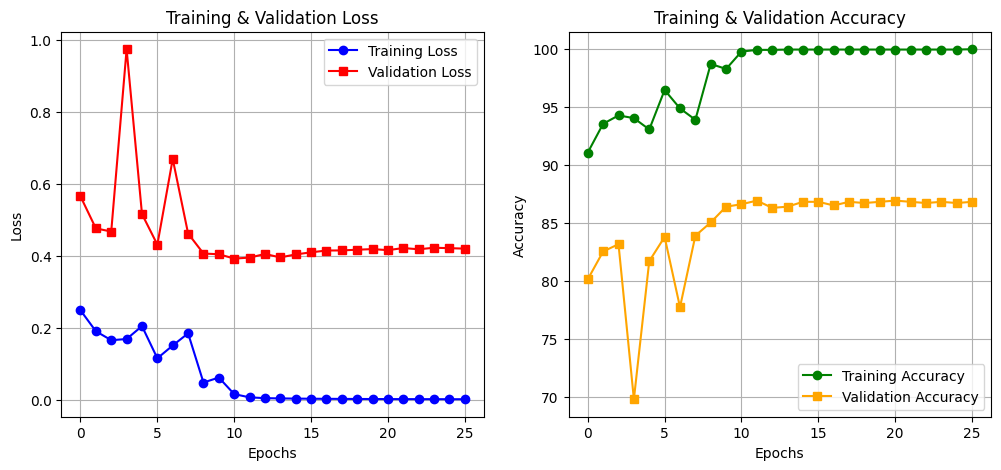


========== Evaluating DeiT-Small V2 on Validation Set ==========


Overall Accuracy: 86.82%
Overall Error Rate: 13.18%
F1-Score (Macro-Averaged): 87.00%
F1-Score (Weighted): 86.76%
Matthews Correlation Coefficient (MCC): 84.61%
Cohen’s Kappa Score: 84.61%
Top-1 Accuracy (%): 86.82%
Top-5 Accuracy (%): 99.90%

Average Inference Time per Image: 0.024680 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          82.50       80.49         81.48            96.46
 BRRI_28          86.92       88.28         87.60            97.95
 BRRI_29          80.62       76.47         78.49            96.95
 BRRI_34          86.96       86.33         86.64            97.80
 BRRI_50          88.46       94.26         91.27            98.20
 BRRI_74          94.12       93.43         93.77            99.02
    BR_5          88.72       90.77         89.73            98.18

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_10

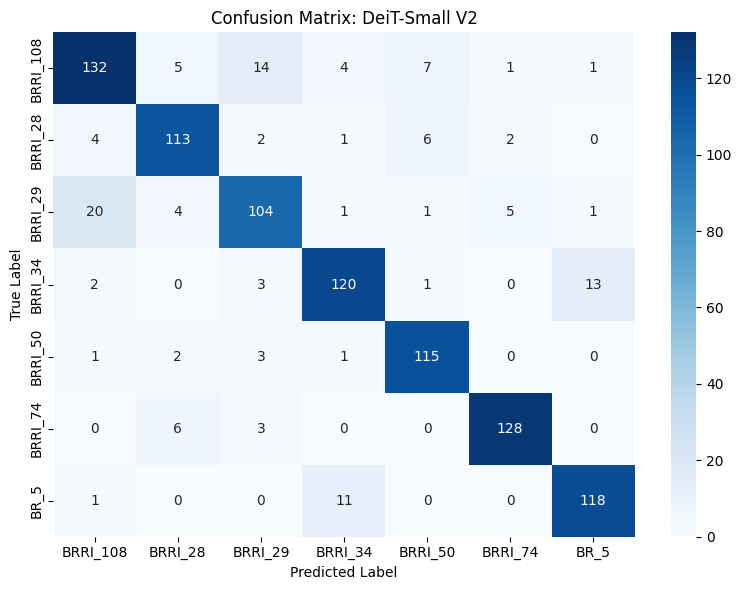

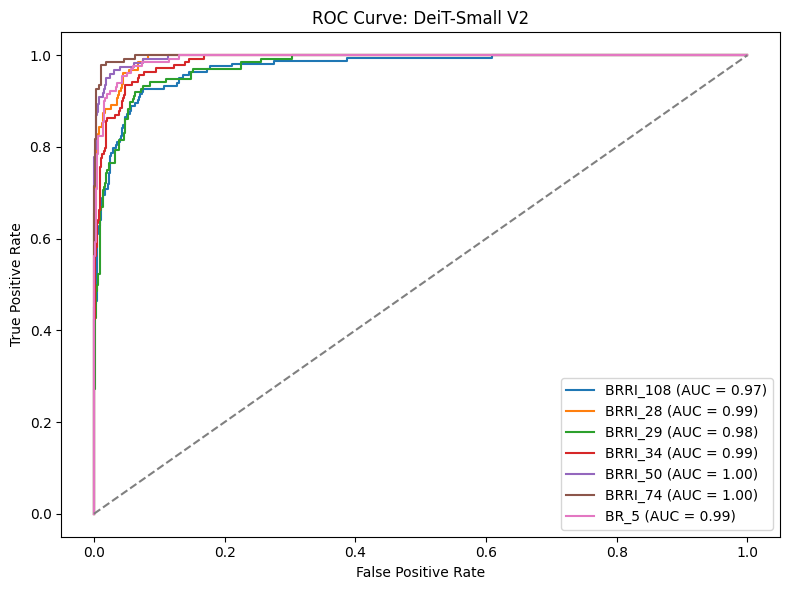

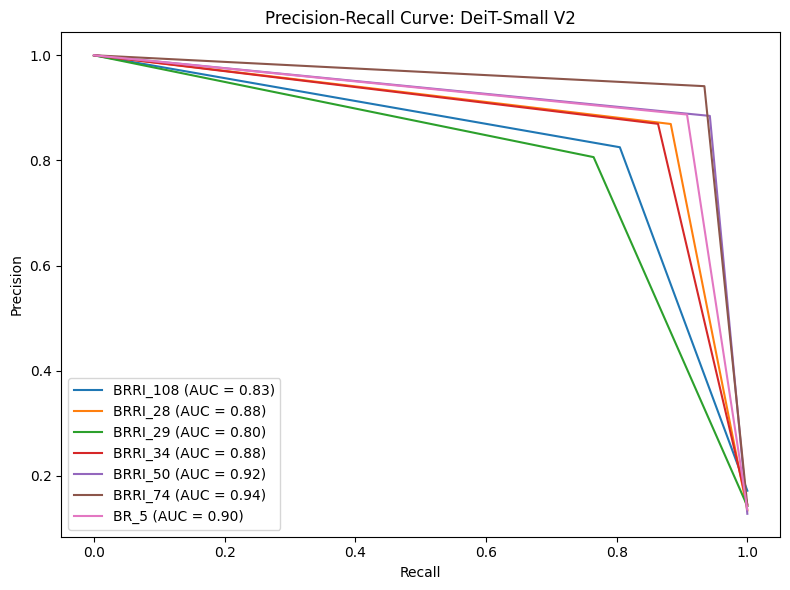


========== Evaluating DeiT-Small V2 on Tesing Set ==========


Overall Accuracy: 87.55%
Overall Error Rate: 12.45%
F1-Score (Macro-Averaged): 87.45%
F1-Score (Weighted): 87.47%
Matthews Correlation Coefficient (MCC): 85.47%
Cohen’s Kappa Score: 85.45%
Top-1 Accuracy (%): 87.55%
Top-5 Accuracy (%): 99.79%

Average Inference Time per Image: 0.025027 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          83.93       73.44         78.33            97.85
 BRRI_28          90.00       87.80         88.89            98.00
 BRRI_29          76.81       79.10         77.94            96.14
 BRRI_34          87.34       89.61         88.46            97.53
 BRRI_50          89.19       97.06         92.96            98.07
 BRRI_74          95.00       93.44         94.21            99.29
    BR_5          90.62       92.06         91.34            98.57

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108   

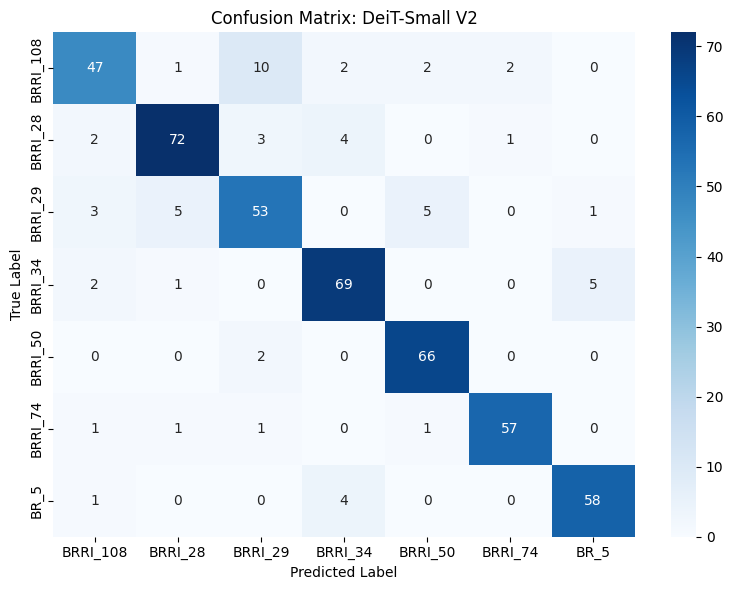

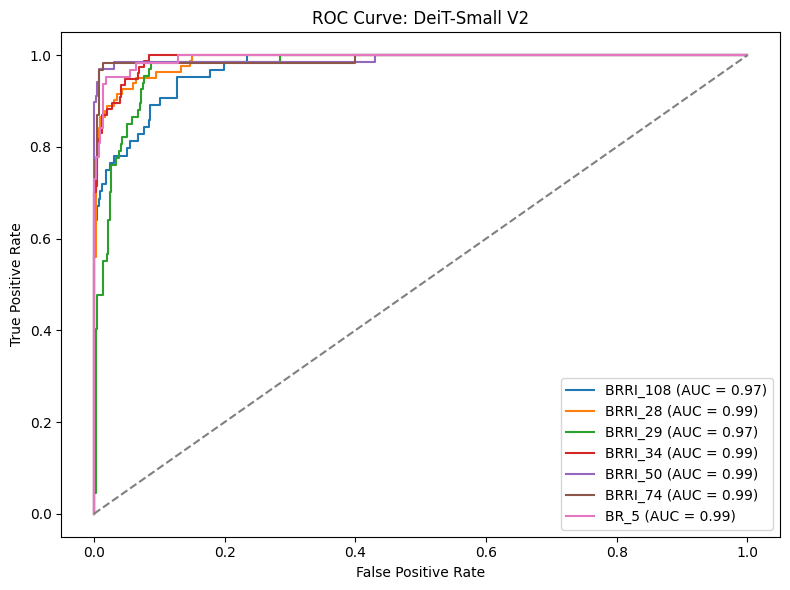

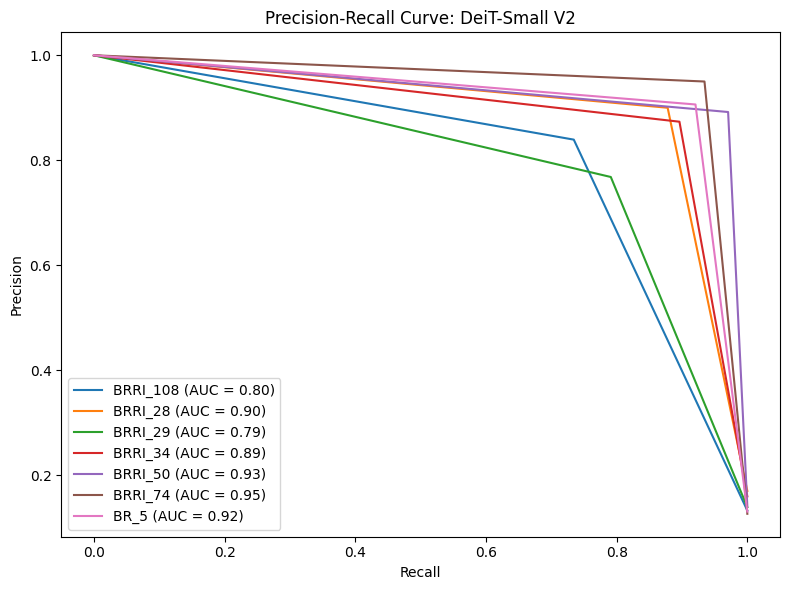

In [35]:
plotting(history2)
metrics = evaluate_model(model2, val_loader, class_names=dataset.classes, loader_name="Validation", model_name="DeiT-Small V2")
metrics = evaluate_model(model2, test_loader, class_names=dataset.classes, loader_name="Tesing", model_name="DeiT-Small V2")